In [13]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [15]:
from matplotlib import pyplot as plt


# 实现注意力的可视化
# 输入matrices的形状是（要显示的行数，要显示的列数，查询的数目，键的数目）
# 每个矩阵（查询数目 × 键数目）对应一个子图。

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """显示矩阵热图"""
    # 使用 Matplotlib 的 rcParams 来设置 SVG 格式
    plt.rcParams['figure.dpi'] = 120  # 调整分辨率
    plt.rcParams['savefig.format'] = 'svg'  # 设置保存格式为 SVG

    # 获取矩阵的行列数
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]

    # 绘图相关参数讲解
    # num_rows, num_cols 子图网格的行列数
    # figsize 整个图像的宽度和高度
    # sharex=True, sharey=True 所有子图共享相同的x轴刻度
    # squeeze=False 无论子图网格的形状如何，axes 始终是一个二维数组。
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    # axes 的形状：(num_rows, num_cols)

    # 遍历每一行的子图和对应的矩阵
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        # 遍历每一列的子图和对应的矩阵
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])

    # 添加颜色条
    fig.colorbar(pcm, ax=axes, shrink=0.6)
    plt.show()

In [16]:
# 通过在最后一个轴上掩蔽元素来执行softmax操作
def masked_softmax(X, valid_lens):
    # X：一个 3D 张量（通常表示批量数据的某种特征矩阵或注意力分数）
    #valid_lens：合法长度，可以是 1D 或 2D 张量，用于指定每个序列的有效长度（非填充部分）
    if valid_lens is None:
        # 无遮掩 直接进行Softmax
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            # 如果 valid_lens 是 1D 张量，则将其重复扩展到与 X 的第二维度（shape[1]）一致
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            # 如果 valid_lens 是 2D 张量，则将其展平为 1D 张量
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [17]:
# 使用小样本进行演示
# (批量大小,序列长度,特征维度)
# 两个样本的有效长度分别为2和3
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.2941, 0.7059, 0.0000, 0.0000],
         [0.4747, 0.5253, 0.0000, 0.0000]],

        [[0.3180, 0.3776, 0.3044, 0.0000],
         [0.3884, 0.2414, 0.3703, 0.0000]]])

In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2408, 0.4528, 0.3064, 0.0000]],

        [[0.5330, 0.4670, 0.0000, 0.0000],
         [0.2736, 0.2137, 0.1850, 0.3277]]])

In [24]:
# 加性注意力的实现
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        # 输入: queries(2, 1, 20)  keys(2, 10, 2)
        # W_q(query_size, num_hiddens) = (20, 8)
        # queries = W_q* queries (2, 1, 20)->(2, 1, 20)*(20, 8)->(2, 1, 8)
        # 输入: keys(2, 10, 2)
        # w_k(key_size, num_hiddens) = (2, 8)
        # keys = W_k* keys (2, 10, 2)->(2, 10, 2)*(2, 8)->(2, 10, 8)
        queries, keys = self.W_q(queries), self.W_k(keys)
        # queries.unsqueeze(2) (2, 1, 8)->(2, 1, 1, 8)
        # keys.unsqueeze(1) (2, 10, 8) -> (2, 1, 10, 8)
        # 广播 features=(2, 1, 1, 8)+(2, 1, 10, 8)= (2, 1, 10, 8)
        # 扩展维度的目的是为了计算查询和键之间的所有组合关系
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        # 输入激活函数改变维度
        features = torch.tanh(features)
        # w_v (8, 1)
        # features*w_v 然后清除最后一个维度 (2, 1, 10, 8)*(8, 1) = (2, 1, 10, 1)->(2, 1, 10)
        scores = self.w_v(features).squeeze(-1)
        # 进行遮蔽 不影响形状
        self.attention_weights = masked_softmax(scores, valid_lens)
        # 进行批量矩阵乘法 (2, 1, 10)*(2, 10, 4)-> (2, 1, 4) 输出结果因为进行的是批量矩阵乘法
        return torch.bmm(self.dropout(self.attention_weights), values)

In [23]:
# 计算过程详解
# queries = torch.normal(0, 1, (2, 1, 20))
# 形状: (batch_size, num_queries, query_size) = (2, 1, 20)  两个批量 每个批量一个查询 查询特征维度20
# keys = torch.ones((2, 10, 2))
# 形状: (batch_size, num_keys, key_size) = (2, 10, 2) 两个批量 每个批量有十个键 键特征维度2
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values形状: (batch_size, num_keys, value_dim) = (2, 10, 4) 两个批量 每个批量有十个值 键特征维度4
# 使用repeat使得每个批量对应的值是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
# 定义有效长度
valid_lens = torch.tensor([2, 6])
# 初始化
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
# 计算过程详见实现类前向传播过程
attention(queries, keys, values, valid_lens).size()

torch.Size([2, 1, 4])

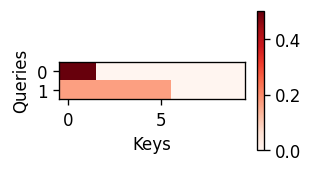

In [20]:
# 尽管加性注意力包含了可学习的参数，但由于本例子中每个键都是相同的，所以注意力权重是均匀的，由指定的有效长度决定。
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [25]:
# 缩放点积注意力的实现
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
# keys = torch.ones((2, 10, 2))
# 形状: (batch_size, num_keys, key_size) = (2, 10, 2) 两个批量 每个批量有十个键 键特征维度2
# values形状: (batch_size, num_keys, value_dim) = (2, 10, 4) 两个批量 每个批量有十个值 键特征维度4
# 使用repeat使得每个批量对应的值是相同的
    def forward(self, queries, keys, values, valid_lens=None):
        # d = 2
        d = queries.shape[-1]
        # bmm批量计算(2,1,2)*(2,2,10)-> (2,1,10)
        # 设置transpose_b=True为了交换keys的最后两个维度
        # keys.transpose(1, 2) 的形状为 (batch_size, d, num_keys) = (2, 2, 10)
        # / math.sqrt(d)是进行缩放
        # 未缩放的分数可能会过大，导致 Softmax 输出极端分布。缩放后分数范围更合理，防止梯度消失
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [26]:
# queries形状: (batch_size, num_queries, query_size)=(2,1,2)  两个批量 每个批量一个查询 查询特征维度2
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

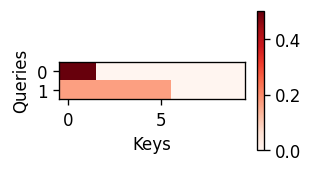

In [27]:
# 由于键包含的是相同的元素， 而这些元素无法通过任何查询进行区分，因此获得了均匀的注意力权重。
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

# 缩放点积注意力（Scaled Dot-Product Attention）详解

缩放点积注意力是Transformer模型的核心机制，最早在2017年发表的《Attention Is All You Need》论文中提出。这个机制是现代自然语言处理模型（如BERT、GPT等）的基础。

## 基本原理

缩放点积注意力的计算公式如下：

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

其中：
- **Q（查询矩阵）**：代表我们想要关注的内容
- **K（键矩阵）**：用于与查询进行匹配
- **V（值矩阵）**：实际被提取的信息
- **d_k**：键向量的维度

## 工作流程

1. **计算相似度**：首先计算查询 (Q) 和键 (K) 之间的点积，得到注意力分数（$$QK^T$$）。
2. **缩放**：将点积除以 $$\sqrt{d_k}$$ 进行缩放，防止梯度消失问题。
3. **Softmax归一化**：对缩放后的分数应用 softmax 函数，获得注意力权重。
4. **加权求和**：用这些权重对值 (V) 进行加权求和。

## 为什么需要缩放？

当输入维度 $$d_k$$ 较大时，点积的结果值会变得很大，导致 softmax 函数梯度接近零。通过除以 $$\sqrt{d_k}$$，可以保持点积结果的方差大约为1，使 softmax 函数工作在梯度更为敏感的区域。

## 多头注意力

在实际应用中，通常使用**多头注意力**（Multi-Head Attention），即多个缩放点积注意力的并行计算：

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O
$$

其中：

$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
$$

- **W_i^Q, W_i^K, W_i^V**：是不同头的线性变换矩阵。
- **W^O**：是输出的线性变换矩阵。

多头注意力允许模型在不同位置和不同表示子空间中共同注意信息。

## 应用优势

1. **并行计算**：与RNN相比，自注意力机制可以并行处理整个序列。
2. **长距离依赖**：能够直接建模序列中任意位置的依赖关系。
3. **可解释性**：注意力权重可视化后能显示模型关注的部分。

缩放点积注意力是现代深度学习模型中的重要组成部分，其简单而高效的设计使得复杂的序列建模任务变得可能。